In [52]:
import os
import json
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime
from pandas.io.json import json_normalize

In [49]:
# path
data_path = os.path.join("..", "data")
open_scale_path = os.path.join(data_path, "OpenScale", "openScale.db")
waistline_path = os.path.join(data_path, "WaistLine", "waistline_export.json")
output_path = os.path.join(data_path, "output")

### OpenScale

In [44]:
# load data
db = sqlite3.connect(open_scale_path)
open_scale = pd.read_sql_query("SELECT * from scaleMeasurements", db)
users = pd.read_sql_query("SELECT * from scaleUsers", db)
db.close()

# remove disabled
open_scale = open_scale[open_scale.enabled == 1]

# select columns
open_scale = open_scale[["userId", "datetime", "weight"]]
users = users[["id", "username", "bodyHeight"]]

# join tables
open_scale = open_scale.set_index("userId").join(users.set_index("id"))

# set datetime index
open_scale.datetime = pd.to_datetime(open_scale.datetime.apply(lambda x: datetime.fromtimestamp(x/1e3)))
open_scale = open_scale.set_index(["datetime"])

# calculate bmi
open_scale["bmi"] = open_scale.apply(lambda x: x.weight/(x.bodyHeight/100)**2, axis=1)

print(open_scale.head())

                        weight      username  bodyHeight        bmi
datetime                                                           
2022-03-06 12:15:00  66.949997  Heiko Raible       176.0  21.613506
2022-03-07 14:20:00  67.199997  Heiko Raible       176.0  21.694214
2022-03-08 10:48:00  67.400002  Heiko Raible       176.0  21.758781
2022-03-09 14:02:00  67.500000  Heiko Raible       176.0  21.791064
2022-03-10 14:39:00  67.500000  Heiko Raible       176.0  21.791064


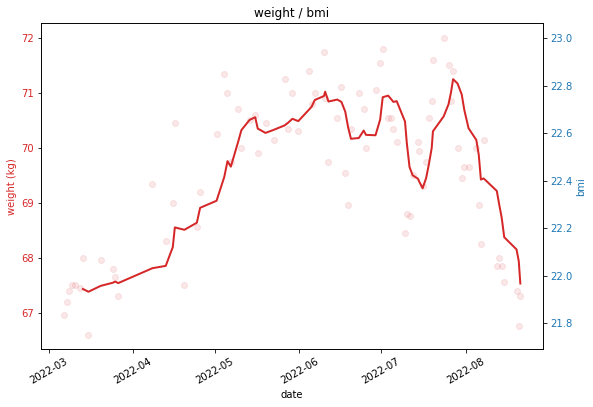

In [45]:
# user heiko
data = open_scale[open_scale.username == "Heiko Raible"]

fig, ax1 = plt.subplots(figsize=(9, 6))

# colors
color = "tab:red"
color2 = "tab:blue"

# ax1
weight = ax1.plot(data.index, data.weight.rolling(7).mean(), linestyle="solid", linewidth=2, color=color)
ax1.scatter(data.index, data.weight, color=color, alpha=0.1)
ax1.set_ylabel("weight (kg)")
ax1.tick_params(axis="y", labelcolor=color)
ax1.yaxis.label.set_color(color)

# ax2
ax2 = ax1.twinx()
bmi = ax2.plot(data.index, data.bmi.rolling(7).mean(), color=(0,0,0,0))
ax2.set_ylabel("bmi")
ax2.tick_params(axis="y", labelcolor=color2)
ax2.yaxis.label.set_color(color2)

# x axis
ax1.set_xlabel("date")
ax1.tick_params(axis="x", rotation=30)

# settings
plt.title("weight / bmi")
plt.show()
fig.savefig(os.path.join(output_path, "weight_bmi.png"), bbox_inches="tight", facecolor="white")